In [96]:
import pandas as pd
import numpy as np
import pymc3 as pm
import graphviz
import arviz as az
import seaborn as sns
from scipy.stats import norm

In [97]:
df = pd.read_csv('pres-data.csv', index_col=0).reset_index().query("year < 2021")
df = df.rename({
    'Housing Inventory: Median Listing Price':'med_housing',
    'Unemployment Rate':'unemployment',
    'All Employees: Federal Government	Housing Inventory: Median Home Size in ':'govt_employees',
    'Housing Inventory: Median Days on Market':'housing_mkt_days',
    'Housing Inventory: New Listing Count':'housing_listings',
    'All Employees: Financial Activities':'financial_act',
    'All Employees: Education and Health Services':'educ_health',
    'All Employees: Federal Government':'fed_employees',
    'Resident Population':'population',
    'Per Capita Personal Income':'income',
    'Housing Inventory: Median Home Size in Square Feet':'home_size'
}, axis=1)

df.insert(0, 'year_month', df.year + df.month/100)

df = df.drop(columns=[
        'financial_act',
        'fed_employees',
        'educ_health',
        'home_size',
        'housing_mkt_days'
])

df

,year_month,year,month,city,state,med_housing,unemployment,housing_listings,population,income
0,2016.07,2016,7,Atlanta,GA,272000.0,5.1,14848.0,5791.874,48657.0
1,2016.08,2016,8,Atlanta,GA,269900.0,5.1,13340.0,5791.874,48657.0
2,2016.09,2016,9,Atlanta,GA,270168.0,5.1,13404.0,5791.874,48657.0
3,2016.10,2016,10,Atlanta,GA,269900.0,5.1,12996.0,5791.874,48657.0
4,2016.11,2016,11,Atlanta,GA,269900.0,5.1,10848.0,5791.874,48657.0
...,...,...,...,...,...,...,...,...,...,...
244,2020.08,2020,8,Tulsa,OK,282000.0,6.6,1112.0,1006.411,58071.0
245,2020.09,2020,9,Tulsa,OK,281250.0,6.0,1036.0,1006.411,58071.0
246,2020.10,2020,10,Tulsa,OK,275000.0,5.3,1048.0,1006.411,58071.0
247,2020.11,2020,11,Tulsa,OK,267450.0,5.1,992.0,1006.411,58071.0


In [295]:
order = 4

predictors=list(df.columns)[5:]

output='med_zhvi'
predictors

['med_housing', 'unemployment', 'housing_listings', 'population', 'income']

In [296]:
df.query("city=='Tulsa'").head(10)

,year_month,year,month,city,state,med_housing,unemployment,housing_listings,population,income
195,2016.07,2016,7,Tulsa,OK,207000.0,5.0,1468.0,989.124,48508.0
196,2016.08,2016,8,Tulsa,OK,207000.0,5.0,1448.0,989.124,48508.0
197,2016.09,2016,9,Tulsa,OK,199950.0,4.9,1376.0,989.124,48508.0
198,2016.10,2016,10,Tulsa,OK,197900.0,4.9,1316.0,989.124,48508.0
199,2016.11,2016,11,Tulsa,OK,195000.0,4.8,1240.0,989.124,48508.0
200,2016.12,2016,12,Tulsa,OK,192000.0,4.6,900.0,989.124,48508.0
201,2017.01,2017,1,Tulsa,OK,196500.0,4.5,1332.0,991.785,51778.0
202,2017.02,2017,2,Tulsa,OK,199949.5,4.4,1496.0,991.785,51778.0
203,2017.03,2017,3,Tulsa,OK,203768.5,4.4,1612.0,991.785,51778.0
204,2017.04,2017,4,Tulsa,OK,210000.0,4.3,1592.0,991.785,51778.0


We're doing modified autoregression because we're not estimating all of our predictors, we won't have a **prediction** past the next year unless we had a prediction for all of our predictors as well that we could feed back into the model. We'll either only be predicting for the next time slot or we'll have to come up with posterior models for each predictor to then feed back into the model. 

In [297]:
def generate_time_data(df, city, order, predictors):

  df = df.query(F"city== '{city}'").reset_index(drop=True)

  df_input = pd.DataFrame()

  year_months = []

  for period in range(order, len(df)):
    year_month = df.year_month.loc[period]
    # print(year_month)
    df2 = df.loc[period-order:period-1]
    # print(df2)

    df2['step'] = [i for i in range(order)]
    df_pivot = df2.pivot(index='city', columns='step', values=predictors).reset_index()
    df_pivot.columns = [col[0]+"_"+str(col[1]) for col in df_pivot.columns]
    # print(df_pivot)

    # Get relevant outputs
    query = F"year_month == {year_month}"
    for col in predictors:
      df_pivot[col] = df.query(query).reset_index(drop=True)[col].iloc[0]

    df_input = pd.concat([df_input, df_pivot])
    year_months.append(year_month)

  # print(df_input)

  df_input.insert(1, 'year_month',year_months)
  df_input = df_input.reset_index(drop=True)
  # df_input.columns=[str(col[0]) + str(col[1]) for col in df_input.columns.values]
  return df_input

generate_time_data(df=df, city='Tulsa',order=4, predictors = predictors).tail(10)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,med_housing_2,med_housing_3,unemployment_0,unemployment_1,unemployment_2,unemployment_3,housing_listings_0,housing_listings_1,housing_listings_2,housing_listings_3,population_0,population_1,population_2,population_3,income_0,income_1,income_2,income_3,med_housing,unemployment,housing_listings,population,income
40,Tulsa,2020.03,248500.0,249725.0,239900.0,245000.0,3.0,3.0,3.0,3.1,908.0,900.0,1048.0,1120.0,999.348,999.348,1006.411,1006.411,56680.0,56680.0,58071.0,58071.0,256000.0,3.3,1232.0,1006.411,58071.0
41,Tulsa,2020.04,249725.0,239900.0,245000.0,256000.0,3.0,3.0,3.1,3.3,900.0,1048.0,1120.0,1232.0,999.348,1006.411,1006.411,1006.411,56680.0,58071.0,58071.0,58071.0,261700.0,13.7,1048.0,1006.411,58071.0
42,Tulsa,2020.05,239900.0,245000.0,256000.0,261700.0,3.0,3.1,3.3,13.7,1048.0,1120.0,1232.0,1048.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,269500.0,10.1,1124.0,1006.411,58071.0
43,Tulsa,2020.06,245000.0,256000.0,261700.0,269500.0,3.1,3.3,13.7,10.1,1120.0,1232.0,1048.0,1124.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,282450.0,8.5,1132.0,1006.411,58071.0
44,Tulsa,2020.07,256000.0,261700.0,269500.0,282450.0,3.3,13.7,10.1,8.5,1232.0,1048.0,1124.0,1132.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,293750.0,7.7,1164.0,1006.411,58071.0
45,Tulsa,2020.08,261700.0,269500.0,282450.0,293750.0,13.7,10.1,8.5,7.7,1048.0,1124.0,1132.0,1164.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,282000.0,6.6,1112.0,1006.411,58071.0
46,Tulsa,2020.09,269500.0,282450.0,293750.0,282000.0,10.1,8.5,7.7,6.6,1124.0,1132.0,1164.0,1112.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,281250.0,6.0,1036.0,1006.411,58071.0
47,Tulsa,2020.10,282450.0,293750.0,282000.0,281250.0,8.5,7.7,6.6,6.0,1132.0,1164.0,1112.0,1036.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,275000.0,5.3,1048.0,1006.411,58071.0
48,Tulsa,2020.11,293750.0,282000.0,281250.0,275000.0,7.7,6.6,6.0,5.3,1164.0,1112.0,1036.0,1048.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,267450.0,5.1,992.0,1006.411,58071.0
49,Tulsa,2020.12,282000.0,281250.0,275000.0,267450.0,6.6,6.0,5.3,5.1,1112.0,1036.0,1048.0,992.0,1006.411,1006.411,1006.411,1006.411,58071.0,58071.0,58071.0,58071.0,270512.0,4.9,652.0,1006.411,58071.0


## Format Data for model input

In [298]:
input = generate_time_data(df=df, city='Atlanta',order=4, predictors = predictors)
input.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


,city_,year_month,med_housing_0,med_housing_1,med_housing_2,med_housing_3,unemployment_0,unemployment_1,unemployment_2,unemployment_3,housing_listings_0,housing_listings_1,housing_listings_2,housing_listings_3,population_0,population_1,population_2,population_3,income_0,income_1,income_2,income_3,med_housing,unemployment,housing_listings,population,income
0,Atlanta,2016.11,272000.0,269900.0,270168.0,269900.0,5.1,5.1,5.1,5.1,14848.0,13340.0,13404.0,12996.0,5791.874,5791.874,5791.874,5791.874,48657.0,48657.0,48657.0,48657.0,269900.0,5.1,10848.0,5791.874,48657.0
1,Atlanta,2016.12,269900.0,270168.0,269900.0,269900.0,5.1,5.1,5.1,5.1,13340.0,13404.0,12996.0,10848.0,5791.874,5791.874,5791.874,5791.874,48657.0,48657.0,48657.0,48657.0,269000.0,5.1,8092.0,5791.874,48657.0
2,Atlanta,2017.01,270168.0,269900.0,269900.0,269000.0,5.1,5.1,5.1,5.1,13404.0,12996.0,10848.0,8092.0,5791.874,5791.874,5791.874,5791.874,48657.0,48657.0,48657.0,48657.0,269900.0,5.0,11676.0,5876.763,51050.0
3,Atlanta,2017.02,269900.0,269900.0,269000.0,269900.0,5.1,5.1,5.1,5.0,12996.0,10848.0,8092.0,11676.0,5791.874,5791.874,5791.874,5876.763,48657.0,48657.0,48657.0,51050.0,274750.0,5.0,13496.0,5876.763,51050.0
4,Atlanta,2017.03,269900.0,269000.0,269900.0,274750.0,5.1,5.1,5.0,5.0,10848.0,8092.0,11676.0,13496.0,5791.874,5791.874,5876.763,5876.763,48657.0,48657.0,51050.0,51050.0,282450.0,4.9,15320.0,5876.763,51050.0


In [299]:
nums = ['0','1','2','3','4','5','6','7','8','9']
columns = [col for col in input.columns if col[-1] in nums]
outputs = [col for col in input.columns[2:] if col[-1] not in nums]

for output in outputs:
  print(F"\t# {output}")
  input_names = []
  for col in columns:
    input_names.append(F"{col}_{output}")
    print(F"\t{col}_{output} = pm.Normal(name='{col}_{output}', mu=0, sigma=sig)")
    # print("")
  print("")
  print(F"\ttheta_{output} = (")  
  for name in columns:
    if name == columns[-1]:
      print(F"\t\t{name}_{output}*input.{name}")
    else:   
      print(F"\t\t{name}_{output}*input.{name}+")
  print("\t)")

  print(F"\t{output} = pm.Normal('{output}', theta_{output}, sd=200, observed=input.{output})")

  print("")


	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	med_housing_2_med_housing = pm.Normal(name='med_housing_2_med_housing', mu=0, sigma=sig)
	med_housing_3_med_housing = pm.Normal(name='med_housing_3_med_housing', mu=0, sigma=sig)
	unemployment_0_med_housing = pm.Normal(name='unemployment_0_med_housing', mu=0, sigma=sig)
	unemployment_1_med_housing = pm.Normal(name='unemployment_1_med_housing', mu=0, sigma=sig)
	unemployment_2_med_housing = pm.Normal(name='unemployment_2_med_housing', mu=0, sigma=sig)
	unemployment_3_med_housing = pm.Normal(name='unemployment_3_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	housing_listings_2_med_housing = pm.Normal(name='housing

# Attempting a combined model for VAR

In [300]:
sig = 1000000
with pm.Model() as model_comb:
	# med_housing
	med_housing_0_med_housing = pm.Normal(name='med_housing_0_med_housing', mu=0, sigma=sig)
	med_housing_1_med_housing = pm.Normal(name='med_housing_1_med_housing', mu=0, sigma=sig)
	med_housing_2_med_housing = pm.Normal(name='med_housing_2_med_housing', mu=0, sigma=sig)
	med_housing_3_med_housing = pm.Normal(name='med_housing_3_med_housing', mu=0, sigma=sig)
	unemployment_0_med_housing = pm.Normal(name='unemployment_0_med_housing', mu=0, sigma=sig)
	unemployment_1_med_housing = pm.Normal(name='unemployment_1_med_housing', mu=0, sigma=sig)
	unemployment_2_med_housing = pm.Normal(name='unemployment_2_med_housing', mu=0, sigma=sig)
	unemployment_3_med_housing = pm.Normal(name='unemployment_3_med_housing', mu=0, sigma=sig)
	housing_listings_0_med_housing = pm.Normal(name='housing_listings_0_med_housing', mu=0, sigma=sig)
	housing_listings_1_med_housing = pm.Normal(name='housing_listings_1_med_housing', mu=0, sigma=sig)
	housing_listings_2_med_housing = pm.Normal(name='housing_listings_2_med_housing', mu=0, sigma=sig)
	housing_listings_3_med_housing = pm.Normal(name='housing_listings_3_med_housing', mu=0, sigma=sig)
	population_0_med_housing = pm.Normal(name='population_0_med_housing', mu=0, sigma=sig)
	population_1_med_housing = pm.Normal(name='population_1_med_housing', mu=0, sigma=sig)
	population_2_med_housing = pm.Normal(name='population_2_med_housing', mu=0, sigma=sig)
	population_3_med_housing = pm.Normal(name='population_3_med_housing', mu=0, sigma=sig)
	income_0_med_housing = pm.Normal(name='income_0_med_housing', mu=0, sigma=sig)
	income_1_med_housing = pm.Normal(name='income_1_med_housing', mu=0, sigma=sig)
	income_2_med_housing = pm.Normal(name='income_2_med_housing', mu=0, sigma=sig)
	income_3_med_housing = pm.Normal(name='income_3_med_housing', mu=0, sigma=sig)

	theta_med_housing = (
		med_housing_0_med_housing*input.med_housing_0+
		med_housing_1_med_housing*input.med_housing_1+
		med_housing_2_med_housing*input.med_housing_2+
		med_housing_3_med_housing*input.med_housing_3+
		unemployment_0_med_housing*input.unemployment_0+
		unemployment_1_med_housing*input.unemployment_1+
		unemployment_2_med_housing*input.unemployment_2+
		unemployment_3_med_housing*input.unemployment_3+
		housing_listings_0_med_housing*input.housing_listings_0+
		housing_listings_1_med_housing*input.housing_listings_1+
		housing_listings_2_med_housing*input.housing_listings_2+
		housing_listings_3_med_housing*input.housing_listings_3+
		population_0_med_housing*input.population_0+
		population_1_med_housing*input.population_1+
		population_2_med_housing*input.population_2+
		population_3_med_housing*input.population_3+
		income_0_med_housing*input.income_0+
		income_1_med_housing*input.income_1+
		income_2_med_housing*input.income_2+
		income_3_med_housing*input.income_3
	)
	med_housing = pm.Normal('med_housing', theta_med_housing, sd=200, observed=input.med_housing)

	# unemployment
	med_housing_0_unemployment = pm.Normal(name='med_housing_0_unemployment', mu=0, sigma=sig)
	med_housing_1_unemployment = pm.Normal(name='med_housing_1_unemployment', mu=0, sigma=sig)
	med_housing_2_unemployment = pm.Normal(name='med_housing_2_unemployment', mu=0, sigma=sig)
	med_housing_3_unemployment = pm.Normal(name='med_housing_3_unemployment', mu=0, sigma=sig)
	unemployment_0_unemployment = pm.Normal(name='unemployment_0_unemployment', mu=0, sigma=sig)
	unemployment_1_unemployment = pm.Normal(name='unemployment_1_unemployment', mu=0, sigma=sig)
	unemployment_2_unemployment = pm.Normal(name='unemployment_2_unemployment', mu=0, sigma=sig)
	unemployment_3_unemployment = pm.Normal(name='unemployment_3_unemployment', mu=0, sigma=sig)
	housing_listings_0_unemployment = pm.Normal(name='housing_listings_0_unemployment', mu=0, sigma=sig)
	housing_listings_1_unemployment = pm.Normal(name='housing_listings_1_unemployment', mu=0, sigma=sig)
	housing_listings_2_unemployment = pm.Normal(name='housing_listings_2_unemployment', mu=0, sigma=sig)
	housing_listings_3_unemployment = pm.Normal(name='housing_listings_3_unemployment', mu=0, sigma=sig)
	population_0_unemployment = pm.Normal(name='population_0_unemployment', mu=0, sigma=sig)
	population_1_unemployment = pm.Normal(name='population_1_unemployment', mu=0, sigma=sig)
	population_2_unemployment = pm.Normal(name='population_2_unemployment', mu=0, sigma=sig)
	population_3_unemployment = pm.Normal(name='population_3_unemployment', mu=0, sigma=sig)
	income_0_unemployment = pm.Normal(name='income_0_unemployment', mu=0, sigma=sig)
	income_1_unemployment = pm.Normal(name='income_1_unemployment', mu=0, sigma=sig)
	income_2_unemployment = pm.Normal(name='income_2_unemployment', mu=0, sigma=sig)
	income_3_unemployment = pm.Normal(name='income_3_unemployment', mu=0, sigma=sig)

	theta_unemployment = (
		med_housing_0_unemployment*input.med_housing_0+
		med_housing_1_unemployment*input.med_housing_1+
		med_housing_2_unemployment*input.med_housing_2+
		med_housing_3_unemployment*input.med_housing_3+
		unemployment_0_unemployment*input.unemployment_0+
		unemployment_1_unemployment*input.unemployment_1+
		unemployment_2_unemployment*input.unemployment_2+
		unemployment_3_unemployment*input.unemployment_3+
		housing_listings_0_unemployment*input.housing_listings_0+
		housing_listings_1_unemployment*input.housing_listings_1+
		housing_listings_2_unemployment*input.housing_listings_2+
		housing_listings_3_unemployment*input.housing_listings_3+
		population_0_unemployment*input.population_0+
		population_1_unemployment*input.population_1+
		population_2_unemployment*input.population_2+
		population_3_unemployment*input.population_3+
		income_0_unemployment*input.income_0+
		income_1_unemployment*input.income_1+
		income_2_unemployment*input.income_2+
		income_3_unemployment*input.income_3
	)
	unemployment = pm.Normal('unemployment', theta_unemployment, sd=200, observed=input.unemployment)

	# housing_listings
	med_housing_0_housing_listings = pm.Normal(name='med_housing_0_housing_listings', mu=0, sigma=sig)
	med_housing_1_housing_listings = pm.Normal(name='med_housing_1_housing_listings', mu=0, sigma=sig)
	med_housing_2_housing_listings = pm.Normal(name='med_housing_2_housing_listings', mu=0, sigma=sig)
	med_housing_3_housing_listings = pm.Normal(name='med_housing_3_housing_listings', mu=0, sigma=sig)
	unemployment_0_housing_listings = pm.Normal(name='unemployment_0_housing_listings', mu=0, sigma=sig)
	unemployment_1_housing_listings = pm.Normal(name='unemployment_1_housing_listings', mu=0, sigma=sig)
	unemployment_2_housing_listings = pm.Normal(name='unemployment_2_housing_listings', mu=0, sigma=sig)
	unemployment_3_housing_listings = pm.Normal(name='unemployment_3_housing_listings', mu=0, sigma=sig)
	housing_listings_0_housing_listings = pm.Normal(name='housing_listings_0_housing_listings', mu=0, sigma=sig)
	housing_listings_1_housing_listings = pm.Normal(name='housing_listings_1_housing_listings', mu=0, sigma=sig)
	housing_listings_2_housing_listings = pm.Normal(name='housing_listings_2_housing_listings', mu=0, sigma=sig)
	housing_listings_3_housing_listings = pm.Normal(name='housing_listings_3_housing_listings', mu=0, sigma=sig)
	population_0_housing_listings = pm.Normal(name='population_0_housing_listings', mu=0, sigma=sig)
	population_1_housing_listings = pm.Normal(name='population_1_housing_listings', mu=0, sigma=sig)
	population_2_housing_listings = pm.Normal(name='population_2_housing_listings', mu=0, sigma=sig)
	population_3_housing_listings = pm.Normal(name='population_3_housing_listings', mu=0, sigma=sig)
	income_0_housing_listings = pm.Normal(name='income_0_housing_listings', mu=0, sigma=sig)
	income_1_housing_listings = pm.Normal(name='income_1_housing_listings', mu=0, sigma=sig)
	income_2_housing_listings = pm.Normal(name='income_2_housing_listings', mu=0, sigma=sig)
	income_3_housing_listings = pm.Normal(name='income_3_housing_listings', mu=0, sigma=sig)

	theta_housing_listings = (
		med_housing_0_housing_listings*input.med_housing_0+
		med_housing_1_housing_listings*input.med_housing_1+
		med_housing_2_housing_listings*input.med_housing_2+
		med_housing_3_housing_listings*input.med_housing_3+
		unemployment_0_housing_listings*input.unemployment_0+
		unemployment_1_housing_listings*input.unemployment_1+
		unemployment_2_housing_listings*input.unemployment_2+
		unemployment_3_housing_listings*input.unemployment_3+
		housing_listings_0_housing_listings*input.housing_listings_0+
		housing_listings_1_housing_listings*input.housing_listings_1+
		housing_listings_2_housing_listings*input.housing_listings_2+
		housing_listings_3_housing_listings*input.housing_listings_3+
		population_0_housing_listings*input.population_0+
		population_1_housing_listings*input.population_1+
		population_2_housing_listings*input.population_2+
		population_3_housing_listings*input.population_3+
		income_0_housing_listings*input.income_0+
		income_1_housing_listings*input.income_1+
		income_2_housing_listings*input.income_2+
		income_3_housing_listings*input.income_3
	)
	housing_listings = pm.Normal('housing_listings', theta_housing_listings, sd=200, observed=input.housing_listings)

	# population
	med_housing_0_population = pm.Normal(name='med_housing_0_population', mu=0, sigma=sig)
	med_housing_1_population = pm.Normal(name='med_housing_1_population', mu=0, sigma=sig)
	med_housing_2_population = pm.Normal(name='med_housing_2_population', mu=0, sigma=sig)
	med_housing_3_population = pm.Normal(name='med_housing_3_population', mu=0, sigma=sig)
	unemployment_0_population = pm.Normal(name='unemployment_0_population', mu=0, sigma=sig)
	unemployment_1_population = pm.Normal(name='unemployment_1_population', mu=0, sigma=sig)
	unemployment_2_population = pm.Normal(name='unemployment_2_population', mu=0, sigma=sig)
	unemployment_3_population = pm.Normal(name='unemployment_3_population', mu=0, sigma=sig)
	housing_listings_0_population = pm.Normal(name='housing_listings_0_population', mu=0, sigma=sig)
	housing_listings_1_population = pm.Normal(name='housing_listings_1_population', mu=0, sigma=sig)
	housing_listings_2_population = pm.Normal(name='housing_listings_2_population', mu=0, sigma=sig)
	housing_listings_3_population = pm.Normal(name='housing_listings_3_population', mu=0, sigma=sig)
	population_0_population = pm.Normal(name='population_0_population', mu=0, sigma=sig)
	population_1_population = pm.Normal(name='population_1_population', mu=0, sigma=sig)
	population_2_population = pm.Normal(name='population_2_population', mu=0, sigma=sig)
	population_3_population = pm.Normal(name='population_3_population', mu=0, sigma=sig)
	income_0_population = pm.Normal(name='income_0_population', mu=0, sigma=sig)
	income_1_population = pm.Normal(name='income_1_population', mu=0, sigma=sig)
	income_2_population = pm.Normal(name='income_2_population', mu=0, sigma=sig)
	income_3_population = pm.Normal(name='income_3_population', mu=0, sigma=sig)

	theta_population = (
		med_housing_0_population*input.med_housing_0+
		med_housing_1_population*input.med_housing_1+
		med_housing_2_population*input.med_housing_2+
		med_housing_3_population*input.med_housing_3+
		unemployment_0_population*input.unemployment_0+
		unemployment_1_population*input.unemployment_1+
		unemployment_2_population*input.unemployment_2+
		unemployment_3_population*input.unemployment_3+
		housing_listings_0_population*input.housing_listings_0+
		housing_listings_1_population*input.housing_listings_1+
		housing_listings_2_population*input.housing_listings_2+
		housing_listings_3_population*input.housing_listings_3+
		population_0_population*input.population_0+
		population_1_population*input.population_1+
		population_2_population*input.population_2+
		population_3_population*input.population_3+
		income_0_population*input.income_0+
		income_1_population*input.income_1+
		income_2_population*input.income_2+
		income_3_population*input.income_3
	)
	population = pm.Normal('population', theta_population, sd=200, observed=input.population)

	# income
	med_housing_0_income = pm.Normal(name='med_housing_0_income', mu=0, sigma=sig)
	med_housing_1_income = pm.Normal(name='med_housing_1_income', mu=0, sigma=sig)
	med_housing_2_income = pm.Normal(name='med_housing_2_income', mu=0, sigma=sig)
	med_housing_3_income = pm.Normal(name='med_housing_3_income', mu=0, sigma=sig)
	unemployment_0_income = pm.Normal(name='unemployment_0_income', mu=0, sigma=sig)
	unemployment_1_income = pm.Normal(name='unemployment_1_income', mu=0, sigma=sig)
	unemployment_2_income = pm.Normal(name='unemployment_2_income', mu=0, sigma=sig)
	unemployment_3_income = pm.Normal(name='unemployment_3_income', mu=0, sigma=sig)
	housing_listings_0_income = pm.Normal(name='housing_listings_0_income', mu=0, sigma=sig)
	housing_listings_1_income = pm.Normal(name='housing_listings_1_income', mu=0, sigma=sig)
	housing_listings_2_income = pm.Normal(name='housing_listings_2_income', mu=0, sigma=sig)
	housing_listings_3_income = pm.Normal(name='housing_listings_3_income', mu=0, sigma=sig)
	population_0_income = pm.Normal(name='population_0_income', mu=0, sigma=sig)
	population_1_income = pm.Normal(name='population_1_income', mu=0, sigma=sig)
	population_2_income = pm.Normal(name='population_2_income', mu=0, sigma=sig)
	population_3_income = pm.Normal(name='population_3_income', mu=0, sigma=sig)
	income_0_income = pm.Normal(name='income_0_income', mu=0, sigma=sig)
	income_1_income = pm.Normal(name='income_1_income', mu=0, sigma=sig)
	income_2_income = pm.Normal(name='income_2_income', mu=0, sigma=sig)
	income_3_income = pm.Normal(name='income_3_income', mu=0, sigma=sig)

	theta_income = (
		med_housing_0_income*input.med_housing_0+
		med_housing_1_income*input.med_housing_1+
		med_housing_2_income*input.med_housing_2+
		med_housing_3_income*input.med_housing_3+
		unemployment_0_income*input.unemployment_0+
		unemployment_1_income*input.unemployment_1+
		unemployment_2_income*input.unemployment_2+
		unemployment_3_income*input.unemployment_3+
		housing_listings_0_income*input.housing_listings_0+
		housing_listings_1_income*input.housing_listings_1+
		housing_listings_2_income*input.housing_listings_2+
		housing_listings_3_income*input.housing_listings_3+
		population_0_income*input.population_0+
		population_1_income*input.population_1+
		population_2_income*input.population_2+
		population_3_income*input.population_3+
		income_0_income*input.income_0+
		income_1_income*input.income_1+
		income_2_income*input.income_2+
		income_3_income*input.income_3
	)
	income = pm.Normal('income', theta_income, sd=200, observed=input.income)
pm.model_to_graphviz(model_comb)

In [301]:
# with model_comb:
#     comb_trace = pm.sample(100)
#     comb_idata = az.from_pymc3(comb_trace)
# post_parameters = az.summary(comb_idata, round_to=2)
# post_parameters

In [302]:
SEED = 12345
np.random.seed(SEED)

# Obtain the variational approximation to the beta
with model_comb:
  approx = pm.fit(50000, method = 'advi', random_seed = SEED)
advi = approx.sample(50000)

Finished [100%]: Average Loss = 2.0325e+05


In [303]:
print(advi.varnames)

values = advi.varnames
means = []
stds = []

for value in advi.varnames:
  means.append(round(np.mean(advi.get_values(value)),3))
  stds.append(round(np.std(advi.get_values(value)),5))

parameters = pd.DataFrame({
    'variable':values,
    'mean':means,
    'std':stds
})

parameters


['med_housing_0_med_housing', 'med_housing_1_med_housing', 'med_housing_2_med_housing', 'med_housing_3_med_housing', 'unemployment_0_med_housing', 'unemployment_1_med_housing', 'unemployment_2_med_housing', 'unemployment_3_med_housing', 'housing_listings_0_med_housing', 'housing_listings_1_med_housing', 'housing_listings_2_med_housing', 'housing_listings_3_med_housing', 'population_0_med_housing', 'population_1_med_housing', 'population_2_med_housing', 'population_3_med_housing', 'income_0_med_housing', 'income_1_med_housing', 'income_2_med_housing', 'income_3_med_housing', 'med_housing_0_unemployment', 'med_housing_1_unemployment', 'med_housing_2_unemployment', 'med_housing_3_unemployment', 'unemployment_0_unemployment', 'unemployment_1_unemployment', 'unemployment_2_unemployment', 'unemployment_3_unemployment', 'housing_listings_0_unemployment', 'housing_listings_1_unemployment', 'housing_listings_2_unemployment', 'housing_listings_3_unemployment', 'population_0_unemployment', 'popul

,variable,mean,std
0,med_housing_0_med_housing,0.133,0.00565
1,med_housing_1_med_housing,0.163,0.00559
2,med_housing_2_med_housing,0.221,0.00576
3,med_housing_3_med_housing,0.301,0.00566
4,unemployment_0_med_housing,0.968,0.71461
...,...,...,...
95,population_3_income,0.088,0.23749
96,income_0_income,0.068,0.03360
97,income_1_income,0.071,0.03121
98,income_2_income,0.076,0.03167


### Generate predictions

# Idea: Generate predictions via manual sampling from the posterior parameters

In [141]:
def get_initial_prediction(input, year_month, order):

  new_df = input.query(F"year_month == {year_month}").reset_index(drop=True)

  city = new_df['city_'].loc[0]
  build_df = pd.Series()

  for col in outputs:
    for i in range(order,0,-1):

      # print(i)

      if i == order:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[col].loc[0]
      else:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[F"{col}_{i}"].loc[0]

  build_df = pd.DataFrame(build_df).transpose()
  build_df.insert(0, 'city_', city)
  build_df.insert(1, 'year_month', year_month)
  return build_df

get_initial_prediction(input=input, year_month=2020.12, order = 2)
df_pred = 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,city_,year_month,med_housing_1,med_housing_0,unemployment_1,unemployment_0,housing_listings_1,housing_listings_0,population_1,population_0,income_1,income_0
0,Atlanta,2020.12,354950.0,369000.0,5.6,5.8,9596.0,14020.0,6087.762,6087.762,58773.0,58773.0


In [304]:
def get_initial_prediction(input, year_month, order):

  new_df = input.query(F"year_month == {year_month}").reset_index(drop=True)

  city = new_df['city_'].loc[0]
  build_df = pd.Series()

  for col in outputs:
    for i in range(order,0,-1):

      # print(i)

      if i == order:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[col].loc[0]
      else:
        new_col = F"{col}_{i-1}"
        build_df[new_col] = new_df[F"{col}_{i}"].loc[0]

  build_df = pd.DataFrame(build_df).transpose()
  build_df.insert(0, 'city_', city)
  build_df.insert(1, 'year_month', year_month)
  return build_df

df_pred = get_initial_prediction(input=input, year_month=2020.12, order = 4)
df_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,city_,year_month,med_housing_3,med_housing_2,med_housing_1,med_housing_0,unemployment_3,unemployment_2,unemployment_1,unemployment_0,housing_listings_3,housing_listings_2,housing_listings_1,housing_listings_0,population_3,population_2,population_1,population_0,income_3,income_2,income_1,income_0
0,Atlanta,2020.12,354950.0,359950.0,369000.0,369000.0,5.6,5.7,5.8,7.0,9596.0,11756.0,14020.0,14460.0,6087.762,6087.762,6087.762,6087.762,58773.0,58773.0,58773.0,58773.0


In [242]:
parameters

,variable,mean,std
0,med_housing_0_med_housing,0.133,0.00566
1,med_housing_1_med_housing,0.163,0.00594
2,med_housing_2_med_housing,0.222,0.00593
3,med_housing_3_med_housing,0.302,0.00570
4,unemployment_0_med_housing,0.972,0.77926
...,...,...,...
95,population_3_income,0.087,0.23872
96,income_0_income,0.068,0.03263
97,income_1_income,0.071,0.03293
98,income_2_income,0.076,0.03291


In [260]:
outputs
print(list(parameters[parameters.variable.str.contains("_med_housing")].variable))
df_pred
order

['med_housing_0_med_housing', 'med_housing_1_med_housing', 'med_housing_2_med_housing', 'med_housing_3_med_housing', 'unemployment_0_med_housing', 'unemployment_1_med_housing', 'unemployment_2_med_housing', 'unemployment_3_med_housing', 'housing_listings_0_med_housing', 'housing_listings_1_med_housing', 'housing_listings_2_med_housing', 'housing_listings_3_med_housing', 'population_0_med_housing', 'population_1_med_housing', 'population_2_med_housing', 'population_3_med_housing', 'income_0_med_housing', 'income_1_med_housing', 'income_2_med_housing', 'income_3_med_housing']


3

In [155]:
df_pred

,city_,year_month,med_housing_2,med_housing_1,med_housing_0,unemployment_2,unemployment_1,unemployment_0,housing_listings_2,housing_listings_1,housing_listings_0,population_2,population_1,population_0,income_2,income_1,income_0
0,Atlanta,2020.12,354950.0,359950.0,369000.0,5.6,5.7,5.8,9596.0,11756.0,14020.0,6087.762,6087.762,6087.762,58773.0,58773.0,58773.0


In [305]:
samples = 10000
order = 4

def get_new_prediction(df_preds, samples, order, df_stdev=pd.DataFrame(), first=True):

  # print(df_preds)
  city = df_preds['city_'].iloc[-1]
  year_month = df_preds['year_month'].iloc[-1]

  month = int(round(100*(year_month % 1),0))
  # print(year_month)
  year = round(year_month, 0)
  if month == 12:
    month = 1
    year += 1
  else:
    month += 1

  # print(month)

  year_month = year + month/100

  df_new = pd.Series()
  df_std = pd.Series()

  for output in outputs:
    # print(output)
    param_list = list(parameters[parameters.variable.str.contains(F"_{output}")].variable)
    sample_array = np.zeros(samples)
    
    for param in param_list:
      
      num = int(param.split(F"_{output}")[0][-1])
      
      if num < order and num > 0:
        # print("Num", num)
        # print(F"{output}_{str(num)}")
        df_new[F"{output}_{str(num-1)}"] = df_preds[F"{output}_{str(num)}"].iloc[-1]
        # print(df_pred[F"{output}_{str(num)}"].iloc[-1])

      mean = parameters.query(F"variable == '{param}'")['mean'].reset_index(drop=True).loc[0]
      std = parameters.query(F"variable == '{param}'")['std'].reset_index(drop=True).loc[0]
      
      if first or param.split(F"_{output}")[0] not in df_stdev.columns:
        # print(param.split(F"_{output}"))
        sample_array += np.random.normal(loc=mean, scale=std, size=samples) * df_preds[param.split(F"_{output}")[0]].iloc[-1]
      else:
        sample_array += np.random.normal(loc=mean, scale=std, size=samples) * np.random.normal(loc=df_preds[param.split(F"_{output}")[0]].iloc[-1], scale=df_stdev[param.split(F"_{output}")[0]].iloc[-1])

    new_average = round(np.mean(sample_array), 2)
    new_std = round(np.std(sample_array),2)

    df_new[F"{output}_{order-1}"] = new_average
    df_std[F"{output}_{order-1}"] = new_std

  df_new = pd.DataFrame(df_new).transpose()
  df_new.insert(0, 'city_', city)
  df_new.insert(1, 'year_month',year_month)
  df_new

  df_std = pd.DataFrame(df_std).transpose()
  df_std.insert(0, 'city_', city)
  df_std.insert(1, 'year_month',year_month)

  # print(list(df_stdev.columns[2:]))
  for col in list(df_stdev.columns[2:]):
    new_num = int(col[-1])-1
    if new_num >= 0:
      new_col = col.replace(col[-1], str(new_num))
      # print(df_stdev[col].iloc[-1])
      df_std[new_col] = df_stdev[col].iloc[-1]

  df_std
  return df_new, df_std

df_mean, df_std = get_new_prediction(df_preds=df_pred, samples=samples, order=order)
df_mean

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city_,year_month,med_housing_0,med_housing_1,med_housing_2,med_housing_3,unemployment_0,unemployment_1,unemployment_2,unemployment_3,housing_listings_0,housing_listings_1,housing_listings_2,housing_listings_3,population_0,population_1,population_2,population_3,income_0,income_1,income_2,income_3
0,Atlanta,2021.01,369000.0,359950.0,354950.0,362132.24,5.8,5.7,5.6,1771.19,14020.0,11756.0,9596.0,15869.26,6087.762,6087.762,6087.762,10662.48,58773.0,58773.0,58773.0,60499.62


In [263]:
df_pred = get_initial_prediction(input=input, year_month=2017.12, order = 4)
df_pred

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  


,city_,year_month,med_housing_3,med_housing_2,med_housing_1,med_housing_0,unemployment_3,unemployment_2,unemployment_1,unemployment_0,housing_listings_3,housing_listings_2,housing_listings_1,housing_listings_0,population_3,population_2,population_1,population_0,income_3,income_2,income_1,income_0
0,Atlanta,2017.12,300000.0,299950.0,299900.0,299900.0,4.2,4.3,4.3,4.4,10096.0,13196.0,14652.0,15132.0,5876.763,5876.763,5876.763,5876.763,51050.0,51050.0,51050.0,51050.0


# Running the Model

In [306]:
order=4
df_pred = get_initial_prediction(input=input, year_month=2017.12, order = order)
samples = 100000
steps = 12
max_num = order-1

mean_df = pd.DataFrame()
std_df = pd.DataFrame()

means, stds = get_new_prediction(df_preds=df_pred, samples=samples, first=True, order=4)
# print(means)
mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
std_df = pd.concat([std_df, stds]).reset_index(drop=True)

for i in range(steps-1):
  means, stds = get_new_prediction(df_preds=means, samples=samples, first=False, df_stdev=stds, order=4)
  mean_df = pd.concat([mean_df, means]).reset_index(drop=True)
  std_df = pd.concat([std_df, stds]).reset_index(drop=True)

mean_df = mean_df[['city_','year_month',F'med_housing_{max_num}']]
mean_df.insert(1, 'year', (round(mean_df.year_month - (mean_df.year_month % 1),0)).astype(int))
mean_df.insert(2, 'month', round(mean_df.year_month%1*100,0).astype(int))
mean_df.insert(3, 'day', 1)
mean_df.insert(4, 'date', pd.to_datetime(mean_df[['year','month','day']]))


std_df = std_df[['city_','year_month',F'med_housing_{max_num}']]
std_df.insert(1, 'year', (round(std_df.year_month - (std_df.year_month % 1),0)).astype(int))
std_df.insert(2, 'month', round(std_df.year_month%1*100,0).astype(int))
std_df.insert(3, 'day', 1)
std_df.insert(4, 'date', pd.to_datetime(std_df[['year','month','day']]))

mean_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:23: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:24: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.


,city_,year,month,day,date,year_month,med_housing_3
0,Atlanta,2018,1,1,2018-01-01,2018.01,303160.43
1,Atlanta,2018,2,1,2018-02-01,2018.02,319237.61
2,Atlanta,2018,3,1,2018-03-01,2018.03,308688.13
3,Atlanta,2018,4,1,2018-04-01,2018.04,299280.22
4,Atlanta,2018,5,1,2018-05-01,2018.05,341274.48
5,Atlanta,2018,6,1,2018-06-01,2018.06,295780.47
6,Atlanta,2018,7,1,2018-07-01,2018.07,353417.91
7,Atlanta,2018,8,1,2018-08-01,2018.08,256210.02
8,Atlanta,2018,9,1,2018-09-01,2018.09,394437.47
9,Atlanta,2018,10,1,2018-10-01,2018.10,232845.98


In [287]:
std_df

,city_,year,month,day,date,year_month,med_housing_4
0,Atlanta,2018,1,1,2018-01-01,2018.01,9847.81
1,Atlanta,2018,2,1,2018-02-01,2018.02,11534.21
2,Atlanta,2018,3,1,2018-03-01,2018.03,38613.73
3,Atlanta,2018,4,1,2018-04-01,2018.04,24178.29
4,Atlanta,2018,5,1,2018-05-01,2018.05,31447.29
5,Atlanta,2018,6,1,2018-06-01,2018.06,37996.72
6,Atlanta,2018,7,1,2018-07-01,2018.07,36727.28
7,Atlanta,2018,8,1,2018-08-01,2018.08,33098.73
8,Atlanta,2018,9,1,2018-09-01,2018.09,57532.37
9,Atlanta,2018,10,1,2018-10-01,2018.10,100107.45


# Visualize

In [307]:
mean_df

,city_,year,month,day,date,year_month,med_housing_3
0,Atlanta,2018,1,1,2018-01-01,2018.01,303160.43
1,Atlanta,2018,2,1,2018-02-01,2018.02,319237.61
2,Atlanta,2018,3,1,2018-03-01,2018.03,308688.13
3,Atlanta,2018,4,1,2018-04-01,2018.04,299280.22
4,Atlanta,2018,5,1,2018-05-01,2018.05,341274.48
5,Atlanta,2018,6,1,2018-06-01,2018.06,295780.47
6,Atlanta,2018,7,1,2018-07-01,2018.07,353417.91
7,Atlanta,2018,8,1,2018-08-01,2018.08,256210.02
8,Atlanta,2018,9,1,2018-09-01,2018.09,394437.47
9,Atlanta,2018,10,1,2018-10-01,2018.10,232845.98


In [309]:
df_line1 = df.query("year > 2016 & year < 2019 & city == 'Atlanta'")
df_line1['type'] = 'actual'

df_line2 = mean_df.rename({"med_housing_3":"med_housing"},axis=1)
df_line2['type'] = 'prediction'

df_line = pd.concat([df_line1,df_line2])
df_line.day = 1
df_line['date']= (pd.to_datetime(df_line[['year','month','day']]))

df_line = df_line[['city','date','med_housing','type']].reset_index(drop=True)
df_line

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,city,date,med_housing,type
0,Atlanta,2017-01-01,269900.00,actual
1,Atlanta,2017-02-01,274750.00,actual
2,Atlanta,2017-03-01,282450.00,actual
3,Atlanta,2017-04-01,297000.00,actual
4,Atlanta,2017-05-01,299900.00,actual
5,Atlanta,2017-06-01,299900.00,actual
6,Atlanta,2017-07-01,297984.00,actual
7,Atlanta,2017-08-01,299900.00,actual
8,Atlanta,2017-09-01,299900.00,actual
9,Atlanta,2017-10-01,299900.00,actual


Text(0.5, 1.0, 'Meidan Housing Price in Atlanta - Actual v Prediction (VAR order 5)')

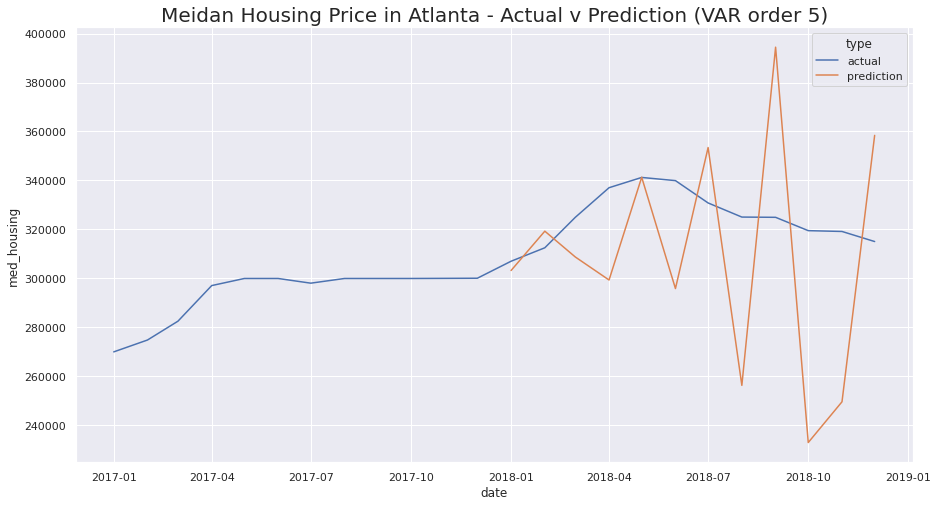

In [312]:
sns.set(rc = {'figure.figsize':(15,8)})

sns.lineplot(data=df_line, x='date',y='med_housing',hue='type').set_title("Meidan Housing Price in Atlanta - Actual v Prediction (VAR order 5)", fontsize=20)

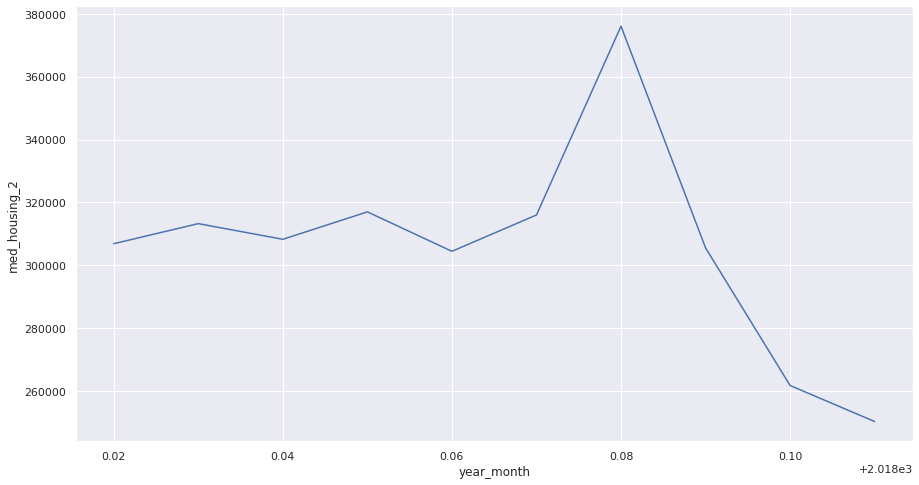

In [164]:
|sns.lineplot(data=mean_df, x='year_month', y='med_housing_2')

,median_housing_price,pdf,months_in_future
0,277858.63,2.115742e-08,1
1,277958.63,2.253574e-08,1
2,278058.63,2.399785e-08,1
3,278158.63,2.554843e-08,1
4,278258.63,2.719241e-08,1
...,...,...,...
15857,507709.74,2.179848e-09,8
15858,507809.74,2.166066e-09,8
15859,507909.74,2.152365e-09,8
15860,508009.74,2.138745e-09,8


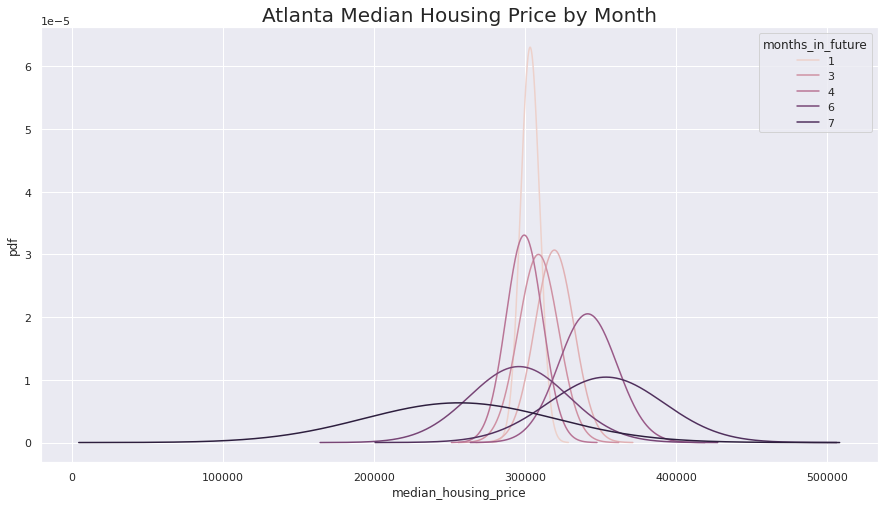

In [316]:
xs = []
ys = []
dists = []
for dist in range(8):
  mean = mean_df.med_housing_3.loc[dist]
  std = std_df.med_housing_3.loc[dist]
  new_xs = np.arange(-4*std+mean, 4*std+mean, 100)
  xs.extend(new_xs)
  ys.extend(norm.pdf(new_xs, mean, std))
  dists.extend([dist+1 for i in range(len(new_xs))])

plot_df = pd.DataFrame({
  'median_housing_price':xs,
  'pdf':ys,
  'months_in_future':dists    
})

sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=plot_df, x='median_housing_price',y='pdf', hue='months_in_future').set_title("Atlanta Median Housing Price by Month", fontsize=20)
plot_df

Text(0.5, 0.98, 'Distribution of prediction by month')

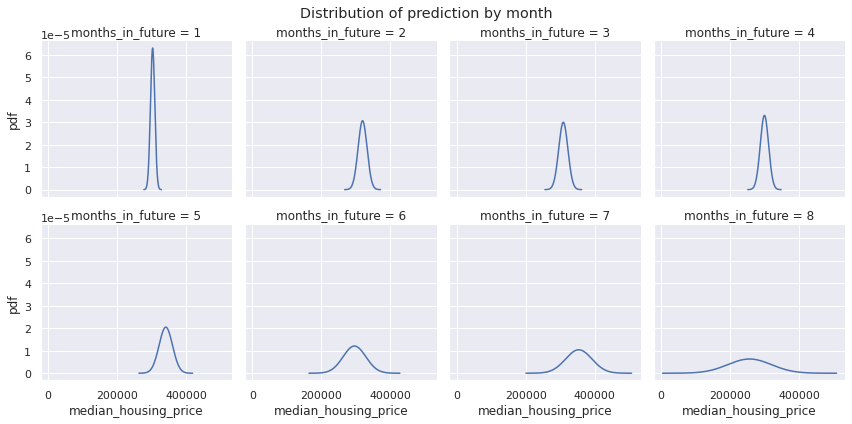

In [321]:
sns.set(rc = {'figure.figsize':(20,12)})

g = sns.FacetGrid(plot_df, col="months_in_future", col_wrap=4)
g.map(sns.lineplot, "median_housing_price", "pdf")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Distribution of prediction by month")

### Test out multiple iterations

In [116]:
temp, stds = get_predictions(df=cville, year=2020, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2)

new_pred, new_std = get_predictions(df=temp, year=2021, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=stds)

pred3, std3 = get_predictions(df=new_pred, year=2022, post_parameters=post_parameters, 
                prediction_suffixes=['_pop', '_zhvi','_death'], 
                predictor_fields=['popestimate_census','med_zhvi','deaths_census'],
                order=2, first=False, df_std=new_std)
pred3

NameError: ignored

In [ ]:
new_std

* Build out posterior predictive sampling
* Process to feed posterior prediction back into autoregression
* Model for top 5 MSAs
  * Function that takes in MSA name, and predictors, and ouputs formatted dataframe
  * Function that builds model to give autoregression posterior predictive parameters
  * 
* Process to join top 5 MSA model to city specific data
* Visuals of output